In [14]:
import numpy as np
import pandas as pd
import math
import random
import plotly.graph_objects as go
from scipy.stats import rankdata
import matplotlib.pyplot as plt


In [9]:
from IPython.utils.py3compat import decode
class Genetic_algorithm():
  def __init__(self,lower,upper,N_ind = 20, L_var = 4, Pc = 0.95, Pm = 0.05,Maximize = True):
    self.N_ind = N_ind
    self.L_var = L_var
    self.lower = lower
    self.upper = upper
    self.N_var = len(lower)
    self.L_ind = L_var * self.N_var
    self.Pc = Pc
    self.Pm = Pm
    self.Maximize = Maximize

  def initial_population(self):
    N_ind = self.N_ind
    L_ind = self.L_ind
    random_numbers = np.random.rand(N_ind * L_ind)
    random_numbers = [0 if number <= 0.5 else 1 for number in random_numbers]
    g = np.array(random_numbers,dtype=np.float64).reshape(N_ind, L_ind)
    return g

  def decode(self,gen):
    N_ind = self.N_ind
    L_ind = self.L_ind
    lower = self.lower
    upper = self.upper
    N_var = self.N_var
    L_var = self.L_var

    phenotype = np.zeros((N_ind,N_var),dtype=np.float64)

    for i in range(N_ind):
      for j in range(N_var):
        phenotype[i,j] = lower[j] + np.sum((2 ** np.arange(0,L_var,1)) * gen[i,(j*L_var):((j+1)*L_var)]) * ((upper[j]- lower[j])/(2 ** L_var - 1))

    return phenotype

  def cross(self,gen):
    N_ind = self.N_ind
    L_ind = self.L_ind
    Pc = self.Pc


    aux_gen = np.zeros((N_ind,L_ind),dtype=np.float64)

    par = L_ind % 2

    for i in range(N_ind-1):
      if np.random.rand(1)[0] <= Pc:
        corte = random.choice(list(range(L_ind)))
        aux_gen[i,] = np.concatenate((gen[i,0:corte], gen[i + 1,corte:(L_ind + 1)]))
        aux_gen[i+1,] = np.concatenate((gen[i + 1,0:corte], gen[i,corte:(L_ind + 1)]))
      else:
        aux_gen[i,] = gen[i,]
        aux_gen[i + 1,] = gen[i + 1,]

      if par == 1:
        aux_gen[N_ind-1,] = gen[N_ind-1,]

    return aux_gen

  """def mutate(self,gen):
    Pm = self.Pm
    N_ind = self.N_ind
    L_ind = self.L_ind

    for i in range(N_ind):
      if np.random.rand(1)[0] <= Pm:
        bit = random.choice(list(range(L_ind)))
        gen[i,bit] = 1 - gen[i,bit]

    return gen"""


  def mutate(self,gen):
    Pm = self.Pm
    N_ind = self.N_ind
    L_ind = self.L_ind

    for i in range(N_ind):
      for j in range(L_ind):
        if np.random.rand(1)[0] <= Pm:
          gen[i,j] = 1 - gen[i,j]
        else:
          gen[i,j] =  gen[i,j]
    return gen

  def selection(self,gen,fitness_function):
    N_ind = self.N_ind
    phenotype = self.decode(gen)
    fitness_vector = fitness_function(phenotype = phenotype)

    if self.Maximize == True:
      prob = ((1/rankdata(-fitness_vector))/np.sum(1/rankdata(-fitness_vector)))
    else:
      prob = ((1/rankdata(fitness_vector))/np.sum(1/rankdata(fitness_vector)))

    parent = np.random.choice(np.arange(N_ind), size = N_ind, p = prob, replace=True)
    gen = gen[parent,]
    return gen



# Testing the Algorithm for a function of two variables

$$\text{Max }Z = -X ^2 - Y ^2$$

In [52]:
import plotly.graph_objects as go
x = np.linspace(-5, 5, 100)
y = np.linspace(-5, 5, 100)
X, Y = np.meshgrid(x, y)
Z = -X**2 - Y**2

fig = go.Figure(data=[go.Surface(z=Z, x=X, y=Y)])


fig.update_layout(scene=dict(
    xaxis_title='X',
    yaxis_title='Y',
    zaxis_title='Z',
))

fig.show()

Now, we will create the fitness function, remembering that the decode method returns an array with the number of rows equal to the number of individuals and the number of columns equal to the number of variables.

In [53]:
def f(phenotype):
  fitness = -phenotype[:,0]**2 - phenotype[:,1]**2
  return fitness


Having the fitness function, the algorithm can be implemented with the desired iterations

In [54]:

fitness = list()
ag = Genetic_algorithm(lower = [-5,-5], upper = [5,5], N_ind = 100, L_var = 8, Pm = 0.05, Maximize = True)
gen = ag.initial_population()

for i in range(20):
  gen = ag.selection(gen = gen, fitness_function = f)
  gen = ag.cross(gen)
  gen = ag.mutate(gen)
  fitness.append(max(f(ag.decode(gen))))


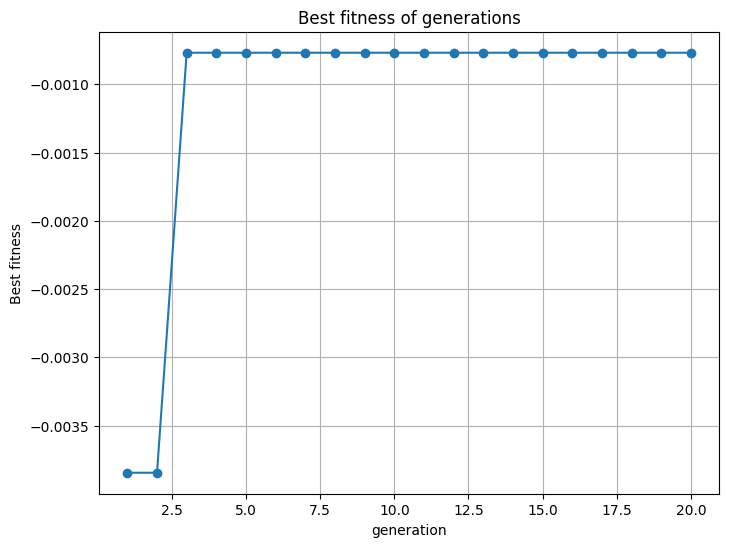

In [55]:
import matplotlib.pyplot as plt
generations = list(range(1, len(fitness) + 1))
plt.figure(figsize=(8, 6))
plt.plot(generations, fitness, marker='o', linestyle='-')
plt.title("Best fitness of generations")
plt.xlabel('generation')
plt.ylabel('Best fitness')
plt.grid(True)
plt.show()

In [56]:
best_sol = ag.decode(gen)[np.argmax(f(ag.decode(gen)))]
best_sol

array([-0.01960784,  0.01960784])

In [57]:
best_sol = ag.decode(gen)[np.argmax(f(ag.decode(gen)))]

x = np.linspace(-5, 5, 100)
y = np.linspace(-5, 5, 100)
X, Y = np.meshgrid(x, y)
Z = -X**2  - Y**2

fig = go.Figure(data=[go.Surface(z=Z, x=X, y=Y)])

fig.add_trace(go.Scatter3d(x=[best_sol[0]], y=[best_sol[1]], z=[max(f(ag.decode(gen)))],
                           mode='markers', marker=dict(size=8, color='blue')))

fig.update_layout(scene=dict(
    xaxis_title='X',
    yaxis_title='Y',
    zaxis_title='Z',
))


# Now, let's try a more complex function

$$\text{Max } Z = X * sin(4*\pi*X) +  Y * sin(4*\pi*Y)$$

In [58]:
import plotly.graph_objects as go
x = np.linspace(-10, 10, 100)
y = np.linspace(-10, 10, 100)
X, Y = np.meshgrid(x, y)
Z =  X * np.sin(np.pi * 4 * x) + Y* np.sin(np.pi * 4 * Y)


fig = go.Figure(data=[go.Surface(z=Z, x=X, y=Y)])

fig.update_layout(scene=dict(
    xaxis_title='Eje X',
    yaxis_title='Eje Y',
    zaxis_title='Eje Z',
))

fig.show()

In [59]:
def f(phenotype):
  X = phenotype[:,0]
  Y = phenotype[:,1]
  fitness = X * np.sin(np.pi * 4 * X) + Y* np.sin(np.pi * 4 * Y)
  return fitness


In [60]:

fitness = list()
ag = Genetic_algorithm(lower = [-10,-10], upper = [10,10], N_ind = 100, L_var = 16, Pm = 0.05, Maximize = True)
gen = ag.initial_population()

for i in range(50):
  gen = ag.selection(gen = gen, fitness_function = f)
  gen = ag.cross(gen)
  gen = ag.mutate(gen)
  fitness.append(max(f(ag.decode(gen))))


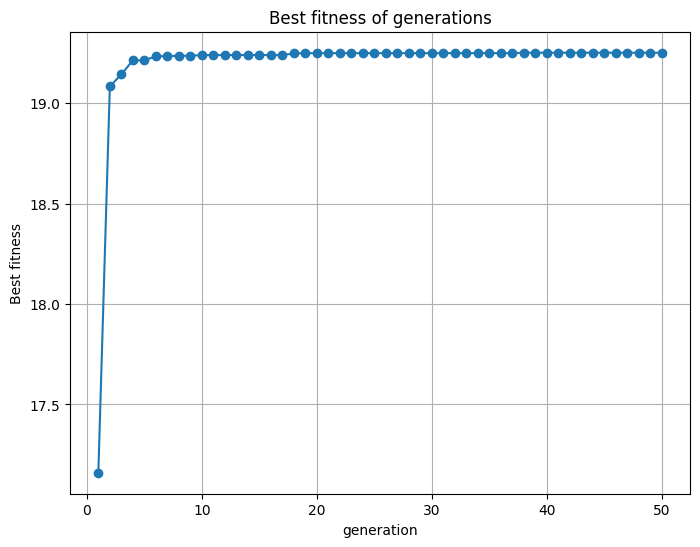

In [61]:
import matplotlib.pyplot as plt
generations = list(range(1, len(fitness) + 1))
plt.figure(figsize=(8, 6))
plt.plot(generations, fitness, marker='o', linestyle='-')
plt.title("Best fitness of generations")
plt.xlabel('generation')
plt.ylabel('Best fitness')
plt.grid(True)
plt.show()

In [62]:
best_sol = ag.decode(gen)[np.argmax(f(ag.decode(gen)))]
best_sol

array([9.6255436, 9.6255436])

In [63]:
import plotly.graph_objects as go
x = np.linspace(-10, 10, 100)
y = np.linspace(-10, 10, 100)
X, Y = np.meshgrid(x, y)
Z =  X * np.sin(np.pi * 4 * x) + Y* np.sin(np.pi * 4 * Y)


fig = go.Figure(data=[go.Surface(z=Z, x=X, y=Y)])

fig.add_trace(go.Scatter3d(x=[best_sol[0]], y=[best_sol[1]], z=[max(f(ag.decode(gen)))],
                           mode='markers', marker=dict(size=8, color='blue')))

fig.update_layout(scene=dict(
    xaxis_title='Eje X',
    yaxis_title='Eje Y',
    zaxis_title='Eje Z',
))

fig.show()

# Now let's try a regression problem

In [64]:

x1 = np.random.normal(5, 2, 300)
x2 = np.random.normal(-10, 3, 300)
error = np.random.normal(0, 10, 300)
y = 20 + 3 * x1 - 7 * x2 + error

# Crear el gráfico 3D de dispersión
scatter = go.Scatter3d(
    x=x1,
    y=x2,
    z=y,
    mode='markers',
    marker=dict(
        size=5,
        color=y,  # Colorear por los valores de 'y'
        colorscale='Viridis',  # Colormap
        opacity=0.8
    )
)

# Definir el diseño del gráfico
layout = go.Layout(
    scene=dict(
        xaxis_title='X1',
        yaxis_title='X2',
        zaxis_title='Y',
    ),
    margin=dict(l=0, r=0, b=0, t=0)
)

# Crear la figura y mostrar el gráfico
fig = go.Figure(data=[scatter], layout=layout)
fig.show()



# Let's define the function of the sum of the quadratic errors

In [65]:
def SSE(phenotype,xx1 = x1,xx2 = x2,y = y):
  b0 = phenotype[:,0]
  b1 = phenotype[:,1]
  b2 = phenotype[:,2]

  fitness = []
  for i in range(phenotype.shape[0]):
    y_hat = b0[i] + b1[i] * xx1 + b2[i] * xx2
    fitness.append(np.sum((y - y_hat) ** 2))

  return fitness


In [66]:
ag = Genetic_algorithm(lower = [-40,-40,-40], upper = [40,40,40], N_ind = 200, L_var = 32, Pm = 0.1, Maximize = False)

gen = ag.initial_population()
fitness = []
for i in range(20):
  gen = ag.selection(gen=gen, fitness_function = SSE)
  gen = ag.cross(gen)
  gen = ag.mutate(gen)
  fitness.append(min(SSE(ag.decode(gen))))


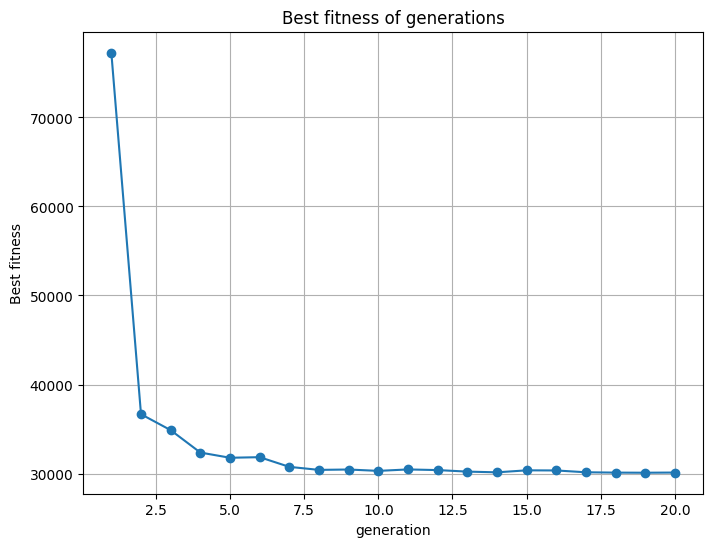

In [67]:
generations = list(range(1, len(fitness) + 1))
plt.figure(figsize=(8, 6))
plt.plot(generations, fitness, marker='o', linestyle='-')
plt.title("Best fitness of generations")
plt.xlabel('generation')
plt.ylabel('Best fitness')
plt.grid(True)
plt.show()


In [68]:
best_sol = ag.decode(gen)[np.argmin(SSE(ag.decode(gen)))]
best_sol

array([18.09145916,  2.45954513, -7.53913633])

In [69]:

scatter = go.Scatter3d(
    x=x1,
    y=x2,
    z=y,
    mode='markers',
    marker=dict(
        size=5,
        color=y,  # Colorear por los valores de 'y'
        colorscale='Viridis',  # Colormap
        opacity=0.8
    )
)

x_plane = np.linspace(min(x1), max(x1), 100)
y_plane = np.linspace(min(x2), max(x2), 100)
x_plane, y_plane = np.meshgrid(x_plane, y_plane)
z_plane = best_sol[0] + best_sol[1] * x_plane + best_sol[2] * y_plane

surface = go.Surface(
    x=x_plane,
    y=y_plane,
    z=z_plane,
    colorscale='Reds',  # Colormap del plano
    opacity=0.5
)

# Definir el diseño del gráfico
layout = go.Layout(
    scene=dict(
        xaxis_title='X1',
        yaxis_title='X2',
        zaxis_title='Y',
    ),
    margin=dict(l=0, r=0, b=0, t=0)
)

# Crear la figura y mostrar el gráfico
fig = go.Figure(data=[scatter, surface], layout=layout)
fig.show()
